### Requirements

In [2]:
!nvidia-smi

Sat Apr 27 10:34:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.03              Driver Version: 535.54.03    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                    0 |
| N/A   28C    P0              90W / 400W |      4MiB / 81920MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [3]:
import os
import sys
sys.path.append("../")

import random
from typing import Tuple, List, Union
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from PIL import Image

import numpy as np
import torchvision
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

from torch.utils.data import DataLoader, TensorDataset, Dataset, Subset, random_split
from transformers import get_cosine_schedule_with_warmup
from diffusers import DDPMScheduler, DDIMScheduler
from sklearn.model_selection import train_test_split

In [9]:
sys.path.append("./improved-diffusion/improved_diffusion")
sys.path.append("./improved-diffusion/")

In [20]:
from dataclasses import dataclass
from typing import Tuple


@dataclass
class TrainingConfig:
    # Data
    image_size = 32

    # Model
    model_channels: int = 128
    num_res_blocks: int = 2
    attention_resolutions: Tuple[int] = (8, 4)

    # Noise Scheduler
    num_train_timesteps = 1_000
    num_inference_steps = 20
    beta_start = 0.0001
    beta_end = 0.02
    beta_schedule = "linear"

    # Training
    batch_size = 32
    epochs = 100
    learning_rate = 1e-4
    lr_warmup_steps = 500

    # Accelerator
    gradient_accumulation_steps = 16
    mixed_precision = 'fp16'  # `no` for float32, `fp16` for automatic mixed precision

    device = "cuda"
    random_state = 42


config = TrainingConfig()

In [5]:
def seed_everything(seed: int,
                    use_deterministic_algos: bool = False) -> None:

    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.use_deterministic_algorithms(use_deterministic_algos)
    random.seed(seed)


seed_everything(config.random_state)

# Data

In [10]:
def show_images(x):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im

In [11]:
def generate(x, model, noise_scheduler, device: str, num_inference_steps: int = 100):
    x, model = x.to(device), model.to(device)
    noise_scheduler.set_timesteps(num_inference_steps=num_inference_steps)
    bs = x.shape[0]
    for i, t in enumerate(noise_scheduler.timesteps):
        model_input = noise_scheduler.scale_model_input(x, t)

        t_batch = torch.full(
            size=(bs,),
            fill_value=t.item(),
            dtype=torch.long
        ).cuda()

        with torch.no_grad():
            noise_pred = model(
                model_input,
                t_batch
            )

        x = noise_scheduler.step(noise_pred, t, x).prev_sample

    return x

In [21]:
from improved_diffusion.unet import UNetModel

model = torch.load("checkpoints/baseline_2/15.pt")

ddim_scheduler = DDIMScheduler(
    num_train_timesteps=config.num_train_timesteps,
    beta_start=config.beta_start,
    beta_end=config.beta_end,
    beta_schedule=config.beta_schedule,

)
ddim_scheduler.set_timesteps(
    num_inference_steps=config.num_inference_steps
)

ddim_scheduler

DDIMScheduler {
  "_class_name": "DDIMScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.02,
  "beta_schedule": "linear",
  "beta_start": 0.0001,
  "clip_sample": true,
  "clip_sample_range": 1.0,
  "dynamic_thresholding_ratio": 0.995,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "rescale_betas_zero_snr": false,
  "sample_max_value": 1.0,
  "set_alpha_to_one": true,
  "steps_offset": 0,
  "thresholding": false,
  "timestep_spacing": "leading",
  "trained_betas": null
}

In [145]:
x_gen = generate(
    torch.randn((1, 1, 32, 32, 32)), 
    model=model,
    noise_scheduler=ddim_scheduler, 
    device="cuda", 
    num_inference_steps=100
).cpu()

x_gen.shape

torch.Size([1, 1, 32, 32, 32])

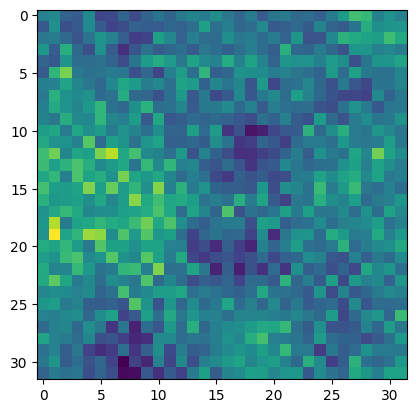

In [146]:
plt.imshow(x_gen[0][0][0])

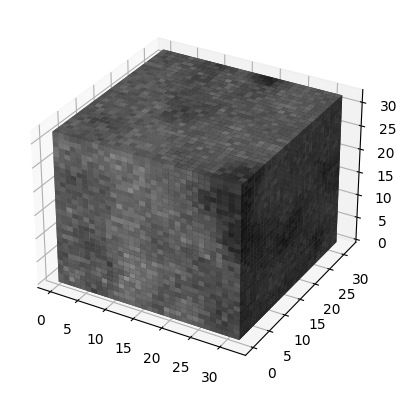

''

In [148]:
show_microstructure(x_gen)